In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import geopandas
import pandas as pd
from osgeo import gdal, gdalconst
import math
from mpl_toolkits.mplot3d import Axes3D



First, we will open our DEM file that is stored as a geotiff in WGS 84 CRS. We will then use gdal.Warp to reproject the file to UTM zone 12N. 

In [2]:
#elev_path = 'C:/Temp/3DEP/3DEP_clipped.tif'
#elev = gdal.Open(elev_UTM_path, gdal.GA_ReadOnly) # open GeoTiff in read only mode
elev_UTM_path = 'C:/Temp/0311/sfm/elevation/elevation.tif'
#warp = gdal.Warp(elev_UTM_path,elev,dstSRS='EPSG:32612') # reproject elevation GeoTiff from WGS to UTM

# close files
warp = None
elev = None

elev_UTM = gdal.Open(elev_UTM_path, gdal.GA_ReadOnly) # open reprojected elevation GeoTiff 

In [3]:
path_to_slope = 'C:/Temp/0311/sfm/slope/slope.tif'
path_to_aspect = 'C:/Temp/0311/sfm/aspect/aspect.tif'

#processing_options = gdal.DEMProcessingOptions(alg = 'ZevenbergenThorne', format = 'GTiff')
#processing_options = gdal.DEMProcessingOptions(alg = 'Horn', format = 'GTiff')

#slope_UTM = gdal.DEMProcessing(path_to_slope, elev_UTM_path, 'slope')
#aspect_UTM = gdal.DEMProcessing(path_to_aspect, elev_UTM_path, 'aspect')

slope_UTM = gdal.Open(path_to_slope, gdal.GA_ReadOnly)
aspect_UTM = gdal.Open(path_to_aspect, gdal.GA_ReadOnly)

In [4]:
#set sensor half FOV to control the footprint area
sensor_half_FOV = 5
sensor_half_FOV_rad = np.radians(sensor_half_FOV)

Next, we need to import our point data and put it into a geopandas geodataframe. Coordinates need to be assigned a CRS, and then projected into UTM Zone 12N

In [5]:
df = pd.DataFrame({'point_name': ['1'], 'lat': [45.23177617], 'lon': [-111.4757019], 'elevation': [2635.52198], 'pitch': [0], 'roll': [0], 'yaw': [90.263]})

gdf = geopandas.GeoDataFrame(df, geometry = geopandas.points_from_xy(df.lon, df.lat)) # create geodataframe and specify coordinate geometry
gdf = gdf.set_crs('EPSG:4326') # set CRS to WGS 84
gdf = gdf.to_crs('EPSG:32612') # project geometry to UTM Zone 12N

point_lon = gdf['geometry'][0].centroid.x # centroid.x is x coordinate of point geometry feature in UTM
point_lat = gdf['geometry'][0].centroid.y # centroid.y is y coordinate of point geometry feature in UTM
point_elev = gdf['elevation'][0]

point_lat, point_lon, point_elev

(5008808.374467916, 462658.882742998, 2635.52198)

Now, we will create a raster that represents the difference in elevation between the sensor and surface.

In [6]:
elev_band = elev_UTM.GetRasterBand(1)
ndv = elev_band.GetNoDataValue()

elev_array = elev_band.ReadAsArray() # read in raster as an array

elev_array[elev_array==ndv]=np.nan # set nan values to np.nan so they do not interfere with calculations
elev_array[elev_array>=point_elev]=np.nan # points above the downward-facing sensor should be masked out as well

elev_diff = point_elev - elev_array # calculate elevation difference

# np.max and np.min will both return nan if there are nan present, so we use np.nanmax and np.nanmin instead
print(np.nanmax(elev_diff)) 
print(np.nanmin(elev_diff))


163.37793
0.00024414062


The next step is to create two rasters that represent the distance on the x and y planes, in meters, from any pixel to the measurement point.

In [34]:
# the raster geotransform tells the precise x,y location of the upper left corner of the upper left pixel, as well as pixel size
'''
geotransform = elev_UTM.GetGeoTransform()

# using this information we will construct arrays for both the x and y coordinates of each pixel in the image
image_shape = np.shape(elev_array)
coordinate_array_x = np.zeros(image_shape)
coordinate_array_y = np.zeros(image_shape)

upper_left_center_x = geotransform[0] + geotransform[1]
upper_left_center_y = geotransform[3] + geotransform[5]

pixel_y = geotransform[3]
pixel_x = geotransform[0]


for row in range(0, image_shape[0]):
    
    pixel_x = geotransform[0]
    pixel_y += geotransform[5]
    
    for col in range(0, image_shape[1]):
        pixel_x += geotransform[1]
        
        coordinate_array_x[row][col] = pixel_x
        coordinate_array_y[row][col] = pixel_y
        
'''
coordinate_array_x = 'C:/Temp/0311/sfm/coords/3DEP_xcoords_res_UTM.tif'
coordinate_array_y = 'C:/Temp/0311/sfm/coords/3DEP_ycoords_res_UTM.tif'
        



In [35]:
# now that we have both coordinate arrays, we can turn them into distance arrays by subtracting the pixel coordinates from the 
# coordinates of the measurement point. Since everything is in UTM this distance is in meters.

dist_x = coordinate_array_y - point_lat
dist_y = coordinate_array_x - point_lon

#notice that x and y are switched here. This is because we need the coordinate system to be in the form of 
#North = x axis, East = y axis, Up/down = z axis




Now we need to determine the equation for the plane of the sensing surface using the pitch, roll, and yaw of the aircraft. The rotation matrix for pitch, roll, and yaw is Rx * Ry * Rz.

Take this sensing surface as the origin with a surface normal (0,0,-1). We need to multiply this by the rotation matrix to get the tilted surface normal.


In [36]:
gdf['pitch_radians'] = np.radians(gdf['pitch'])
gdf['roll_radians'] = np.radians(gdf['roll'])
gdf['yaw_radians'] = np.radians(gdf['yaw'])

In [37]:
surface_normal = [[0],[0],[-1]]

pitch = gdf['pitch_radians'][0]
roll = gdf['roll_radians'][0]
yaw = gdf['yaw_radians'][0]


rot_matrix = [
              [np.cos(yaw)*np.cos(pitch), np.cos(pitch)*np.sin(yaw), -1*np.sin(pitch)],
              [np.cos(yaw)*np.sin(roll)*np.sin(pitch)-np.cos(roll)*np.sin(yaw), np.cos(roll)*np.cos(yaw)+np.sin(roll)*np.sin(yaw)*np.sin(pitch), np.cos(pitch)*np.sin(roll)],
              [np.sin(roll)*np.sin(yaw)+np.cos(roll)*np.cos(yaw)*np.sin(pitch), np.cos(roll)*np.sin(yaw)*np.sin(pitch)-np.cos(yaw)*np.sin(roll), np.cos(roll)*np.cos(pitch)],
             ]

surface_normal = np.dot(rot_matrix, surface_normal)

print(surface_normal)

[[ 0.]
 [ 0.]
 [-1.]]


Let's now plot both the original surface normal, and the new surface normal that is tilted based on aircraft pitch, roll, and yaw.

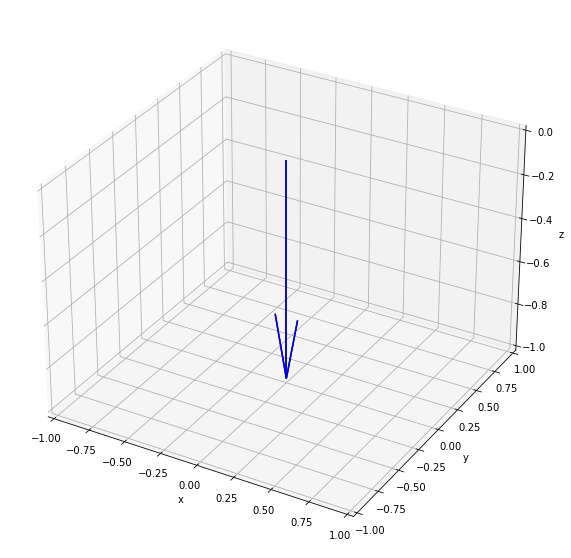

In [38]:
plane_normal = np.array([[0, 0, 0, 0, 0, -1]])
tilted_normal = np.array([[0,0,0, surface_normal[0][0], surface_normal[1][0], surface_normal[2][0]]])

X, Y, Z, U, V, W = zip(*plane_normal)
Xi, Yi, Zi, Ui, Vi, Wi = zip(*tilted_normal)

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111, projection='3d')
ax.quiver(X, Y, Z, U, V, W, color = 'black')
ax.quiver(Xi, Yi, Zi, Ui, Vi, Wi, color = 'blue')


ax.set_ylim(-1,1)
ax.set_xlim(-1,1)
ax.set_zlim(-1,0)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')


plt.show()

Now we will calculate the acute angle between every pixel on the elevation surface and the plane of the sensing surface using some linear algebra magic

In [39]:
angle = np.arcsin(np.abs((surface_normal[0][0] * dist_x + 
                   surface_normal[1][0] * dist_y + 
                   surface_normal[2][0] * -1 * elev_diff) /
                  (np.sqrt(np.square(dist_x)+np.square(dist_y)+np.square(elev_diff)) *
                   np.sqrt(np.square(surface_normal[0][0])+np.square(surface_normal[1][0])+np.square(surface_normal[2][0])
                  ))
                 ))

And we will filter out pixels if the acute angle is less than (90 degrees - the half field of view), or outside the field of view

In [40]:
angle[angle<=(math.pi/2)-sensor_half_FOV_rad]=np.nan

#note that the maximum angle should never greater than 90 degrees (1.5708 rad)
#and the minimum angle should never be less than 90-HFOV (.349066 rad for HFOV = 70 degrees)

print(np.nanmin(angle))
print(np.nanmax(angle))

0.17453559481508366
1.4907395290132253


Now we will calculate a an average slope and aspect based on the weighted average of the cosine of the incidence angle between a pixel and the sensor. We will then calculate a simple arithmetic mean value within the footprint.

In [41]:
cosine_incidence = np.cos((math.pi/2)-angle)
cos_sum = np.nansum(cosine_incidence)
weighting = cosine_incidence/cos_sum

In [42]:
# read in aspect data
aspect_band = aspect_UTM.GetRasterBand(1)
aspect_array = aspect_band.ReadAsArray() # read in raster as an array

# calculate cosine wighted average
aspect_arr_weighted = weighting * aspect_array

weighted_aspect = np.nansum(aspect_arr_weighted)
print('cosine-weighted mean aspect: ' + str(weighted_aspect))

# now calculate arithmetic mean
aspect_arr_masked = aspect_arr_weighted/weighting
mean_aspect = np.nanmean(aspect_arr_masked)
print('arithmetic mean aspect: ' + str(mean_aspect))

cosine-weighted mean aspect: 136.73797639561846
arithmetic mean aspect: 138.3416851789749


In [43]:
# read in slope data
slope_band = slope_UTM.GetRasterBand(1)
slope_array = slope_band.ReadAsArray() # read in raster as an array

# calculate cosine wighted average
slope_arr_weighted = weighting * slope_array

weighted_slope = np.nansum(slope_arr_weighted)
print('cosine-weighted mean slope: ' + str(weighted_slope))

# now calculate arithmetic mean
slope_arr_masked = slope_arr_weighted/weighting
mean_slope = np.nanmean(slope_arr_masked)
print('arithmetic mean slope: ' + str(mean_slope))

cosine-weighted mean slope: 12.137166910103863
arithmetic mean slope: 12.555460166469272


In [44]:
driver = gdal.GetDriverByName("GTiff")
outdata = driver.Create('C:/Temp/weighting_footprint.tif', image_shape[1], image_shape[0], 1, gdalconst.GDT_Float32)
outdata.SetGeoTransform(elev_UTM.GetGeoTransform())##sets same geotransform as input
outdata.SetProjection(elev_UTM.GetProjection())##sets same projection as input
outdata.GetRasterBand(1).WriteArray(weighting)
outdata.GetRasterBand(1).SetNoDataValue(10000)##if you want these values transparent
outdata.FlushCache() ##saves to disk!!
outdata = None
band=None
ds=None